In [182]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import KFold

from sklearn.multiclass import OneVsRestClassifier

from scipy.spatial.distance import cdist

import re

from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
def get_output(better = [False, "noun", 5]):
    if better[0]:
        y = pd.read_csv("better/better_train_{}_tags_{}.csv".format(better[2], better[1]))
    else:
        y = pd.read_csv("processed_tags.csv")
        y.drop(["Name"], axis=1, inplace = True)
    return np.array(y)

In [3]:
def get_data(bad_tags = [False, "noun"], fc = False, pool = False):
    if bad_tags[0]:
        train_lines = np.array([' '.join(f.split()) for i in range(10000) 
                      for f in open("features_train_prepossesing_{}/".format(bad_tags[1])
                                    + str(i) 
                                    + ".txt")])
        unique_words = list(set([item for sublist in train_lines.ravel() for item in sublist.split()]))

        count_vect = TfidfVectorizer(vocabulary = unique_words)
        X_train = count_vect.fit_transform(train_lines)
        X_train = X_train.toarray()

        test_lines = np.array([' '.join(f.split()) for i in range(2000) 
                      for f in open("features_test_prepossesing_{}/".format(bad_tags[1])
                                    + str(i) 
                                    + ".txt")])

        X_test = count_vect.transform(test_lines)
        X_test = X_test.toarray()

    elif fc:
        X_train = pd.read_csv("data/features_train/features_resnet1000_train.csv", 
                              header = None, names = ["Neuron_" + str(i) for i in range(1000)])
        indices = X_train.index
        new_indices = [int(re.findall(r'\d+', ind)[0]) for ind in indices]
        X_train = np.array(pd.DataFrame(np.array(X_train), columns=X_train.columns, index=new_indices).sort_index())
        
        X_test = pd.read_csv("data/features_test/features_resnet1000_test.csv", 
                             header = None, names = ["Neuron_" + str(i) for i in range(1000)])
        indices = X_test.index
        new_indices = [int(re.findall(r'\d+', ind)[0]) for ind in indices]
        X_test = np.array(pd.DataFrame(np.array(X_test), columns=X_test.columns, index=new_indices).sort_index())
    
    elif pool:
        X_train = pd.read_csv("data/features_train/features_resnet1000intermediate_train.csv", 
                              header = None, names = ["Neuron_" + str(i) for i in range(2048)])
        indices = X_train.index
        new_indices = [int(re.findall(r'\d+', ind)[0]) for ind in indices]
        X_train = np.array(pd.DataFrame(np.array(X_train), columns=X_train.columns, index=new_indices).sort_index())
        
        X_test = pd.read_csv("data/features_test/features_resnet1000intermediate_test.csv", 
                             header = None, names = ["Neuron_" + str(i) for i in range(2048)])
        indices = X_test.index
        new_indices = [int(re.findall(r'\d+', ind)[0]) for ind in indices]
        X_test = np.array(pd.DataFrame(np.array(X_test), columns=X_test.columns, index=new_indices).sort_index())
    
    else:
        print("Set Parameters")
        
    return X_train, X_test

In [4]:
def make_better_tags(k, words_type = "noun"):
    X_train, X_test = get_data(bad_tags = [True, words_type])
    
    train_lines = np.array([' '.join(f.split()) for i in range(10000) 
                      for f in open("features_train_prepossesing_{}/".format(words_type)
                                    + str(i) 
                                    + ".txt")])
    
    unique_words = list(set([item for sublist in train_lines.ravel() for item in sublist.split()]))
    
    unique_tags = []
    for arr in X_train:
        tags = [i for i in arr.argsort()[-k:][::-1]]

        for i in tags:
            if unique_words[i] not in unique_tags:
                unique_tags.append(unique_words[i])
    
    print(len(unique_tags))
    
    d = dict([(tag, 0) for tag in unique_tags])
    
    better_tags = []
    for arr in X_train:
        d_sample = d.copy()

        for i in arr.argsort():
            if (arr[i]>0) and (unique_words[i] in unique_tags):
                d_sample[unique_words[i]] = arr[i]
        better_tags.append(list(d_sample.values()))

    print(len(better_tags[0]))

    pd.DataFrame(better_tags, 
                 columns=unique_tags).to_csv("better/better_train_{}_tags_{}.csv".format(k, words_type), 
                                                          index=False)
    
    better_tags = []
    for arr in X_test:
        d_sample = d.copy()

        for i in arr.argsort():
            if (arr[i]>0) and (unique_words[i] in unique_tags):
                d_sample[unique_words[i]] = arr[i]
        better_tags.append(list(d_sample.values()))

    print(len(better_tags[0]))

    pd.DataFrame(better_tags, columns=unique_tags).to_csv("better/better_test_{}_tags_{}.csv".format(k, words_type), 
                                                          index=False)

## Test models

In [6]:
def test_nn(X_train, y, add_tags=True):
    if add_tags:
        tags_train = pd.read_csv("processed_tags.csv")
        tags_train.drop(["Name"], axis=1, inplace = True)
        tags_train = np.array(tags_train)

        X_train = np.hstack((X_train, tags_train))

    print("# of input features {}".format(X_train.shape[1]))
        
    folds = 3
    skf = KFold(n_splits=folds)
    accuracy = []
    
    for train_index, test_index in skf.split(X_train, y):
        print("SPLIT")
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = Sequential()
        model.add(Dense(500, input_dim=x_train.shape[1], init='normal', activation='relu'))
#         model.add(Dropout(0.2))
        model.add(Dense(y_train.shape[1], init='normal', activation='softmax'))

        # Compile model     #logarithmic  loss     #method
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])

        # Fit the model
        model.fit(x_train, y_train, 
                  validation_data=(x_test, y_test),
                  nb_epoch=15, batch_size=100,
                  verbose=1)
        
        accuracy.append(model.evaluate(x_test, y_test)[1])
        print()

    print("Results")
    print("The average accuracy Neural Network is {}".format(np.mean(accuracy)))

In [84]:
make_better_tags(5, words_type="adj")

2488
2488
2488


In [8]:
# test_rf(X_train, y)

In [9]:
# X_train, X_test = get_data(pool=True)
# y = get_output(better=[True, "adj&noun", 5])

# test_nn(X_train, y, add_tags=True)

## Predictions

In [32]:
def nn_predict_description(add_tags=False, better=[True, "adj&noun", 5]):
    X_train, X_test = get_data(pool=True)
    y = get_output(better=better)
    
    if add_tags:
        tags_train = pd.read_csv("processed_tags.csv")
        tags_train.drop(["Name"], axis=1, inplace = True)
        tags_train = np.array(tags_train)
               
        X_train = np.hstack((X_train, tags_train))
        
        
        tags_test = pd.read_csv("processed_tags_test.csv")
        tags_test.drop(["Name"], axis=1, inplace = True)
        tags_test = np.array(tags_test)
                
        X_test = np.hstack((X_test, tags_test))
    
    print("# of input features {}".format(X_train.shape[1]))

    model = Sequential()
    model.add(Dense(500, input_dim=X_train.shape[1], init='normal', activation='relu'))
    model.add(Dense(y.shape[1], init='normal', activation='softmax'))
    
    # Compile model     #logarithmic  loss     #method
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    # Fit the model
    model.fit(X_train, y, 
              nb_epoch=13, batch_size=100,
              verbose=1)

    predicted_tags = model.predict(X_test)
    
    columns = pd.read_csv("better/better_train_{}_tags_{}.csv".format(better[2], better[1])).columns
    
    pd.DataFrame(predicted_tags, 
                 columns=columns).to_csv("Predicted/CNN_predicted_tags.csv", 
                                         index=False)

In [188]:
def MLP_predict_description(add_tags=False, better=[True, "adj&noun", 5]):
    X_train, X_test = get_data(pool=True)
    y = get_output(better=[True, "adj&noun", 5])
    
    if add_tags:
        tags_train = pd.read_csv("processed_tags.csv")
        tags_train.drop(["Name"], axis=1, inplace = True)
        tags_train = np.array(tags_train)
               
        X_train = np.hstack((X_train, tags_train))
        
        tags_test = pd.read_csv("processed_tags_test.csv")
        tags_test.drop(["Name"], axis=1, inplace = True)
        tags_test = np.array(tags_test)
                
        X_test = np.hstack((X_test, tags_test))
    
    y[y != 0] = 1

    model = MLPClassifier(hidden_layer_sizes=(500), verbose=True, max_iter=30, warm_start=True)
    model.fit(X_train, y)
    
    predicted_tags = model.predict(X_test)
    
    columns = pd.read_csv("better/better_train_{}_tags_{}.csv".format(better[2], better[1])).columns
    
    pd.DataFrame(predicted_tags, 
                 columns=columns).to_csv("Predicted/MLP_predicted_tags.csv", 
                                         index=False)

In [204]:
def make_output(mlp=False, nn=False, better=[True, "adj&noun", 5]):
    
    if nn == True:
        groud_truth = pd.read_csv("better/better_test_{}_tags_{}.csv".format(better[2], better[1]))
        predicted = pd.read_csv("Predicted/CNN_predicted_tags.csv")

        simi = cdist(groud_truth, predicted, metric='cosine')
        pd.DataFrame(simi, 
                     columns=list(range(2000))).to_csv("similarity/NN_{}_pool+tags_similarity.csv".format(better[1]), 
                                                             index=False)
        
        rows = []
        k=0
        for row in simi:
            top20 = row.argsort()[:20]
            rows.append([str(k) + ".txt", " ".join([str(value) + ".jpg" for value in top20])])
            k+=1
        pd.DataFrame(rows, 
                     columns=['Descritpion_ID', 'Top_20_Image_IDs']).to_csv("Submissions/CNN_{}_submission.csv".format(better[1]), 
                                                                            index=False)
    elif mlp == True:
        groud_truth = pd.read_csv("better/better_test_{}_tags_{}.csv".format(better[2], better[1]))
        predicted = pd.read_csv("Predicted/MLP_predicted_tags.csv")

        simi = cdist(groud_truth, predicted, metric='cosine')
        pd.DataFrame(simi, 
                     columns=list(range(2000))).to_csv("similarity/MLP_{}_pool+tags_similarity.csv".format(better[1]), 
                                                             index=False)
        
        rows = []
        k=0
        for row in simi:
            top20 = row.argsort()[:20]
            rows.append([str(k) + ".txt", " ".join([str(value) + ".jpg" for value in top20])])
            k+=1
        pd.DataFrame(rows, 
                     columns=['Descritpion_ID', 'Top_20_Image_IDs']).to_csv("Submissions/MLP_{}_submission.csv".format(better[1]), 
                                                                            index=False)
    else:
        1+1
    
    return rows

In [261]:
def make_enseble(models):
    matrices = []
    for key, weight in models.items():
        if key == "best":
            d = pd.read_csv("similarity/NN_best_pool+tags_similarity.csv").drop(["Unnamed: 0"], axis=1)
        else:
            d = pd.read_csv("similarity/{}_{}_pool+tags_similarity.csv".format(key, weight[0]))
        matrices.append(weight[1]*np.array(d))

    matrices = np.array(matrices)
    
    simi = sum(matrices)
    
    images = []
    k=0
    for row in simi:
        top20 = row.argsort()[:20]
        images.append([str(k) + ".txt", " ".join([str(value) + ".jpg" for value in top20])])
        k+=1
        
    pd.DataFrame(images, 
                 columns=['Descritpion_ID', 'Top_20_Image_IDs']).to_csv("Submissions/EN_{}_submission.csv".format(list(models.keys())), 
                                                                        index=False)
    
    return images

## MLP

In [262]:
# MLP_predict_description(add_tags=True, better=[True, "adj&noun", 5])

## Neural Net

In [263]:
# nn_predict_description(add_tags=True, better=[True, "adj&noun", 5])

In [264]:
# images = make_output(mlp=True, better=[True, "adj&noun", 5])

In [279]:
images = make_enseble({"best": ["",0.77], 
                       "NN": ["adj&noun", 0.23]})

In [280]:
# [ 0.86773841  0.06454957]

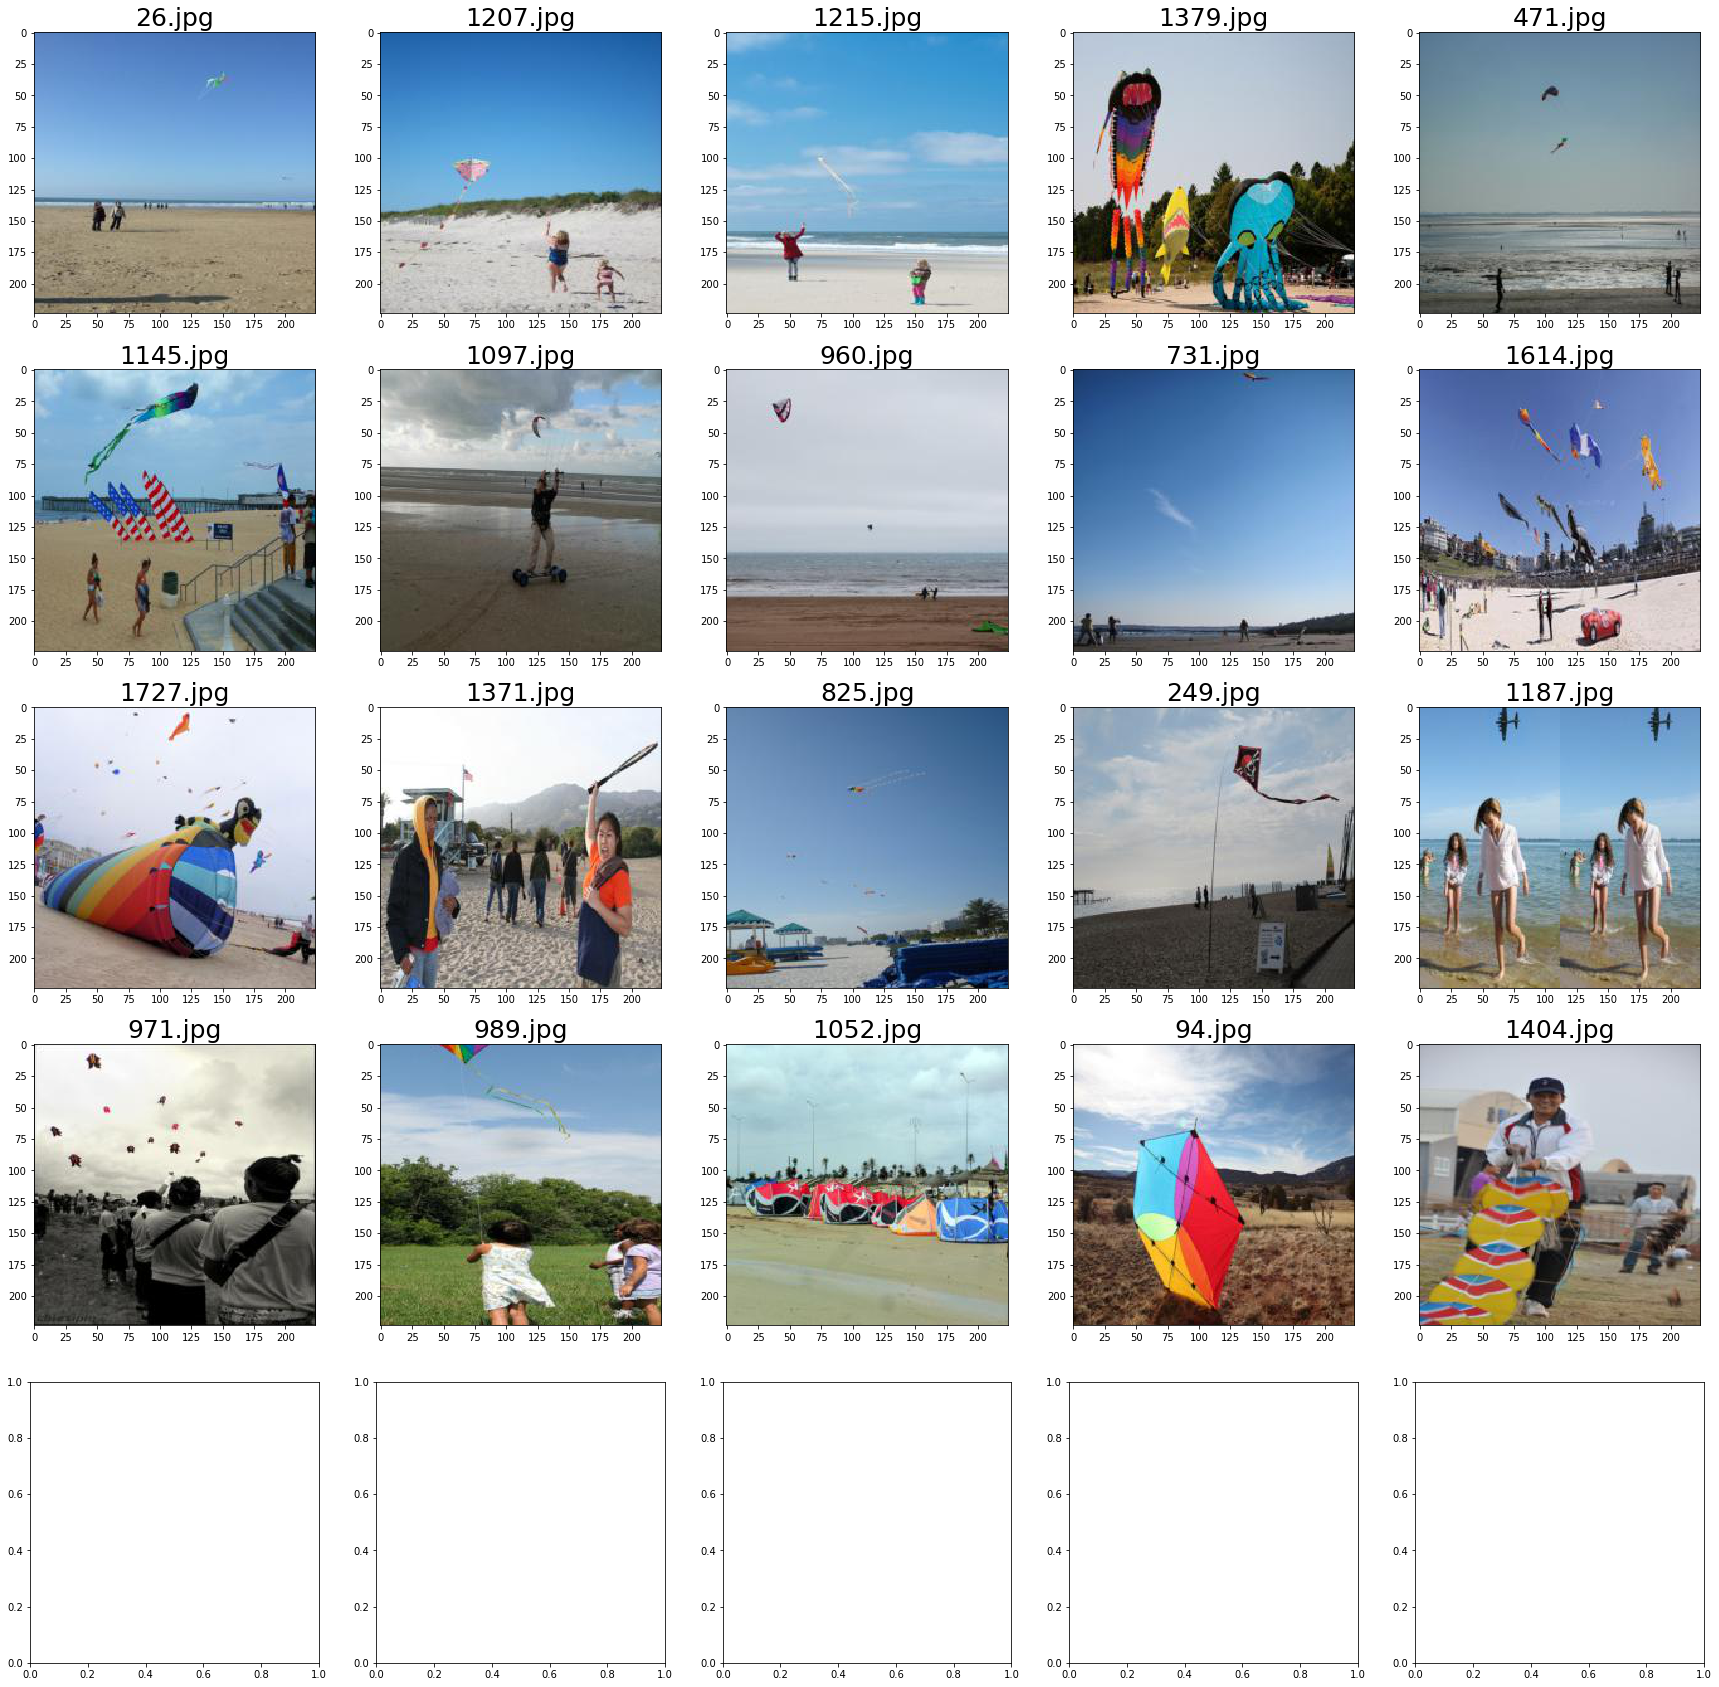

In [281]:
image_to_show = 25

output_statement = images[image_to_show][1]

row, col = 5,5

f, ax = plt.subplots(nrows=row, ncols=col, figsize=(30,30))
for index, image_1 in enumerate(output_statement.split()):
    if index == row*col:
        break
    img=mpimg.imread('data/images_test/' + image_1)
    ax[int(index/row), index%col].set_title(image_1, fontsize=25)
    ax[int(index/row), index%col].imshow(img)

## Tunning

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

def get_simi_for_deb():
    X_train, X_test = get_data(pool=True)
    y = get_output(better=[True, "adj&noun", 5])

    tags_train = pd.read_csv("processed_tags.csv")
    tags_train.drop(["Name"], axis=1, inplace = True)
    tags_train = np.array(tags_train)

    X_train = np.hstack((X_train, tags_train))
    
    X_train = pd.DataFrame(X_train, columns=list(range(X_train.shape[1])))
    
    X_Train, X_Val, Y_train, Y_Val = train_test_split(X_train, y, train_size=0.8)
    
    gt_files = list(X_Val.index)
    
    file = open("Tunning/gt.txt","w") 
 
    for g in gt_files:
        file.write(str(g)+",")

    file.close() 
    
    better_tag_val_data = Y_Val.copy()

    X_Train = np.array(X_Train)
    X_Val = np.array(X_Val)
    Y_train[Y_train != 0] = 1
    Y_Val[Y_Val != 0] = 1
     
    classifier = MLPClassifier(hidden_layer_sizes=(500), verbose=True, max_iter=30, warm_start=True)
    classifier.fit(X_Train, Y_train)
    
    simi = cdist(better_tag_val_data, classifier.predict_proba(X_Val), metric='cosine')
    pd.DataFrame(simi, columns=list(range(simi.shape[1]))).to_csv("Tunning/best.csv", index=False)
    
    model = Sequential()
    model.add(Dense(500, input_dim=X_Train.shape[1], init='normal', activation='relu'))
    model.add(Dense(Y_train.shape[1], init='normal', activation='softmax'))

    # Compile model     #logarithmic  loss     #method
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    # Fit the model
    model.fit(X_Train, Y_train, 
              nb_epoch=13, batch_size=100,
              verbose=1)

    predicted_tags = model.predict(X_Val)

    simi = cdist(better_tag_val_data, predicted_tags, metric='cosine')
    pd.DataFrame(simi, columns=list(range(simi.shape[1]))).to_csv("Tunning/NN.csv", index=False)
    
    return gt_files

In [180]:
from scipy.optimize import minimize

def optimize():
    def get_matrices(models):
        matrices = []
        for key in models:
            matrices.append(np.array(pd.read_csv("Tunning/{}.csv".format(key))))

        matrices = np.array(matrices)

        return matrices
    
    def get_accuracy_on_set(simi):
        
        gt_files = open("Tunning/gt.txt", "r").readlines()[0]
        
        gt_files = gt_files.split(",")[:-1]
        
        score = 0.0
        for i_check in range(len(simi)):
            pred_list = list(simi[i_check].argsort()[:20])

            k = [gt_files[i] for i in pred_list]
            if gt_files[i_check] in k:
                score += float(20 - k.index(gt_files[i_check]))/20

        return -score/2000
    
    matrices = get_matrices(["best", "NN"])
    
    def f(x):
        simi = x[0]*matrices[0] + x[1]*matrices[1]
        return get_accuracy_on_set(simi)

    start_pos = np.array([0.5, 0.5])

    res = minimize(f, start_pos, method='Nelder-Mead')
    coef = res.x
    print(coef)
    print(-get_accuracy_on_set(coef[0]*matrices[0] + coef[1]*matrices[1]))

In [181]:
optimize()

[ 0.86773841  0.06454957]
0.6310750000000024


2001